In [ ]:
# Assignment 3.1: Impacting the Business with a Distributed Data Science Pipeline (Part 2)

In [32]:
#Import raw datasets from AWS S3
!aws s3 ls s3://ads508rawdatasets/

                           PRE queries/
2023-03-20 03:03:47     712668 OHSU_BeatAMLWaves1_2_Tyner_ClinicalSummary.csv
2023-03-20 03:04:55    3909901 opencell-protein-interactions.csv


In [44]:
# Python version
!python --version

Python 3.7.10


In [45]:
!pip list

Package                              Version
------------------------------------ -----------------
absl-py                              1.4.0
aiobotocore                          2.4.2
aiohttp                              3.8.4
aioitertools                         0.11.0
aiosignal                            1.3.1
alabaster                            0.7.12
anaconda-client                      1.7.2
anaconda-project                     0.8.3
ansi2html                            1.8.0
anyio                                3.6.2
argh                                 0.26.2
argon2-cffi                          21.3.0
argon2-cffi-bindings                 21.2.0
asn1crypto                           1.3.0
astroid                              2.15.0
astropy                              4.3.1
astunparse                           1.6.3
async-timeout                        4.0.2
asynctest                            0.13.0
atomicwrites                         1.3.0
attrs                            

In [43]:
#Check Environment
import boto3

region = boto3.Session().region_name
session = boto3.session.Session()

ec2 = boto3.Session().client(service_name="ec2", region_name=region)
sm = boto3.Session().client(service_name="sagemaker", region_name=region)

In [46]:
import json

notebook_instance_name = None

try:
    with open("/opt/ml/metadata/resource-metadata.json") as notebook_info:
        data = json.load(notebook_info)
        domain_id = data["DomainId"]
        resource_arn = data["ResourceArn"]
        region = resource_arn.split(":")[3]
        name = data["ResourceName"]
    print("DomainId: {}".format(domain_id))
    print("Name: {}".format(name))
except:
    print("+++++++++++++++++++++++++++++++++++++++++")
    print("[ERROR]: COULD NOT RETRIEVE THE METADATA.")
    print("+++++++++++++++++++++++++++++++++++++++++")

DomainId: d-hv7wibly91z2
Name: datascience-1-0-ml-t3-medium-fbbacbd136ea35c00e5ce9203df8


In [47]:
describe_domain_response = sm.describe_domain(DomainId=domain_id)
print(describe_domain_response["Status"])

InService


In [48]:
try:
    get_status_response = sm.get_sagemaker_servicecatalog_portfolio_status()
    print(get_status_response["Status"])
except:
    pass

Enabled


In [49]:
## Check Required Settings for Correct Settings
if (
    describe_domain_response["Status"] == "InService"
    and get_status_response["Status"] == "Enabled"
    and "datascience" in name
):
    setup_instance_check_passed = True
    print("[OK] Checks passed!  Great Job!!  Please Continue.")
else:
    setup_instance_check_passed = False
    print("+++++++++++++++++++++++++++++++++++++++++++++++")
    print("[ERROR]: WE HAVE IDENTIFIED A MISCONFIGURATION.")
    print(describe_domain_response["Status"])
    print(get_status_response["Status"])
    print(name)
    print("+++++++++++++++++++++++++++++++++++++++++++++++")

[OK] Checks passed!  Great Job!!  Please Continue.


In [51]:
print(setup_instance_check_passed)

True


In [52]:
%store setup_instance_check_passed

Stored 'setup_instance_check_passed' (bool)


In [53]:
%store

Stored variables and their in-db values:
setup_instance_check_passed             -> True


In [54]:
# Create S3 Bucket
import boto3
import sagemaker

session = boto3.session.Session()
region = session.region_name
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()

s3 = boto3.Session().client(service_name="s3", region_name=region)


In [55]:
setup_s3_bucket_passed = False
print("Default bucket: {}".format(bucket))

Default bucket: sagemaker-us-west-2-135966665220


In [56]:
#Verify S3_Bucket Creation
%%bash

aws s3 ls s3://${bucket}/

2023-03-20 18:03:00 ads508rawdatasets
2023-03-24 06:41:08 sagemaker-us-west-2-135966665220


In [57]:
from botocore.client import ClientError

response = None

try:
    response = s3.head_bucket(Bucket=bucket)
    print(response)
    setup_s3_bucket_passed = True
except ClientError as e:
    print("[ERROR] Cannot find bucket {} in {} due to {}.".format(bucket, response, e))


{'ResponseMetadata': {'RequestId': '62ERM3M5DM9PNQ8Y', 'HostId': 'HuY7Y6oqZ45elaItTexX2KXk4DqxTRhKPkWS7/rm63Ld9hjjseukZqGEKB+9RhNOSSwxDRHbesU=', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amz-id-2': 'HuY7Y6oqZ45elaItTexX2KXk4DqxTRhKPkWS7/rm63Ld9hjjseukZqGEKB+9RhNOSSwxDRHbesU=', 'x-amz-request-id': '62ERM3M5DM9PNQ8Y', 'date': 'Fri, 24 Mar 2023 06:58:18 GMT', 'x-amz-bucket-region': 'us-west-2', 'x-amz-access-point-alias': 'false', 'content-type': 'application/xml', 'server': 'AmazonS3'}, 'RetryAttempts': 0}}


In [60]:
# Update IAM Roles/Policies
import boto3
import sagemaker
import time
from time import gmtime, strftime

sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
bucket = sagemaker_session.default_bucket()
region = boto3.Session().region_name

from botocore.config import Config

config = Config(retries={"max_attempts": 10, "mode": "adaptive"})

iam = boto3.client("iam", config=config)

In [61]:
# Retrieve SageMaker Execution Role Name
role_name = role.split("/")[-1]
print("Role name: {}".format(role_name))

Role name: AmazonSageMaker-ExecutionRole-20230319T210510


In [62]:
setup_iam_roles_passed = False

In [66]:
s3_private_path_csv = "s3://{}/cell_data".format(bucket)
print(s3_private_path_csv)

s3://sagemaker-us-west-2-135966665220/cell_data


In [67]:
%store s3_private_path_csv

Stored 's3_private_path_csv' (str)


In [68]:
print(s3_private_path_csv)

s3://sagemaker-us-west-2-135966665220/cell_data


In [65]:
!aws s3 ls $se_private_path_csv/

2023-03-20 18:03:00 ads508rawdatasets
2023-03-24 06:41:08 sagemaker-us-west-2-135966665220


In [69]:
from IPython.core.display import display, HTML

display(
    HTML(
        '<b>Review <a target="blank" href="https://s3.console.aws.amazon.com/s3/buckets/sagemaker-{}-{}/cell_data/?region={}&tab=overview">S3 Bucket</a></b>'.format(
            region, account_id, region
        )
    )
)

In [58]:
%store setup_s3_bucket_passed

Stored 'setup_s3_bucket_passed' (bool)


In [59]:
%store

Stored variables and their in-db values:
setup_instance_check_passed             -> True
setup_s3_bucket_passed                  -> True


In [70]:
# Retrive subset of dataset
!aws s3 cp 's3://ads508rawdatasets/OHSU_BeatAMLWaves1_2_Tyner_ClinicalSummary.csv' ./data/

download: s3://ads508rawdatasets/OHSU_BeatAMLWaves1_2_Tyner_ClinicalSummary.csv to data/OHSU_BeatAMLWaves1_2_Tyner_ClinicalSummary.csv


In [71]:
import csv 

df = pd.read_csv('s3://ads508rawdatasets/OHSU_BeatAMLWaves1_2_Tyner_ClinicalSummary.csv')

In [72]:
df.shape

(672, 159)

In [73]:
df.head(5)

,LabId,PatientId,consensus_sex,inferred_sex,inferred_ethnicity,centerID,CEBPA_Biallelic,ageAtDiagnosis,isRelapse,isDenovo,...,STAG2,STAT3,SUZ12,TCL1A,TET2,TP53,TYK2,U2AF1,WT1,ZRSR2
0,09-00705,163,Male,Male,White,1,n,73.0,False,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10-00136,174,Male,Male,White,1,n,69.0,False,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10-00172,175,Female,Male,White,1,n,59.0,False,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10-00507,45,Female,Female,White,1,n,70.0,False,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10-00542,174,Male,Male,White,1,n,69.0,True,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [75]:
!aws s3 cp 's3://ads508rawdatasets/opencell-protein-interactions.csv' ./data/

download: s3://ads508rawdatasets/opencell-protein-interactions.csv to data/opencell-protein-interactions.csv


In [76]:
df2 = pd.read_csv('s3://ads508rawdatasets/opencell-protein-interactions.csv')
df2.shape

(29922, 9)

In [77]:
df2.head()

,target_gene_name,interactor_gene_name,target_ensg_id,interactor_ensg_id,interactor_uniprot_ids,pval,enrichment,interaction_stoichiometry,abundance_stoichiometry
0,AAMP,ARGLU1,ENSG00000127837,ENSG00000134884,Q9NWB6;Q9NWB6-3;Q9NWB6-2,5.495914,2.868131,0.128618,0.222927
1,AAMP,CWF19L2,ENSG00000127837,ENSG00000152404,Q2TBE0;Q2TBE0-2;H7C3G7;Q2TBE0-3;H0YE03,5.480125,2.889502,0.022009,0.063036
2,AAMP,PRPF40A,ENSG00000127837,ENSG00000196504,A0A3F2YNY6;O75400-2;O75400-3;O75400;H0YG38;F5H578,5.321102,3.228531,0.001582,0.742017
3,AAMP,RPL10,ENSG00000127837,ENSG00000147403,X1WI28;P27635;B8A6G2;A6QRI9;Q96L21,15.156173,4.847218,0.521148,13.146910
4,AAMP,RSRC1,ENSG00000127837,ENSG00000174891,Q96IZ7-2;Q96IZ7;H7C5Q0;C9J713;C9J367;C9J8Q2;C9...,5.929453,3.239392,0.013171,0.210926


In [81]:
sex = pd.DataFrame(df['inferred_sex'].value_counts())
sex                

,inferred_sex
Male,384
Female,284
Female;Male,2


In [82]:
relapse = pd.DataFrame(df['isRelapse'].value_counts())
relapse

,isRelapse
False,626
True,46


In [83]:
denovo = pd.DataFrame(df['isDenovo'].value_counts())
denovo

,isDenovo
False,384
True,288


In [84]:
gene = pd.DataFrame(df2['target_gene_name'].value_counts())
gene

,target_gene_name
CAPZB,755
CANX,400
HIST2H2BE,358
SSRP1,357
YWHAE,338
...,...
SLC11A2,1
SLC15A4,1
SLC16A10,1
SLC16A2,1


In [85]:
interactor = pd.DataFrame(df2['interactor_gene_name'].value_counts())
interactor

,interactor_gene_name
POLR2E,62
RPS8,61
RPS4X,59
EIF3A,56
RPL22,53
...,...
NUF2,1
MTUS1,1
EXPH5,1
ETAA1,1


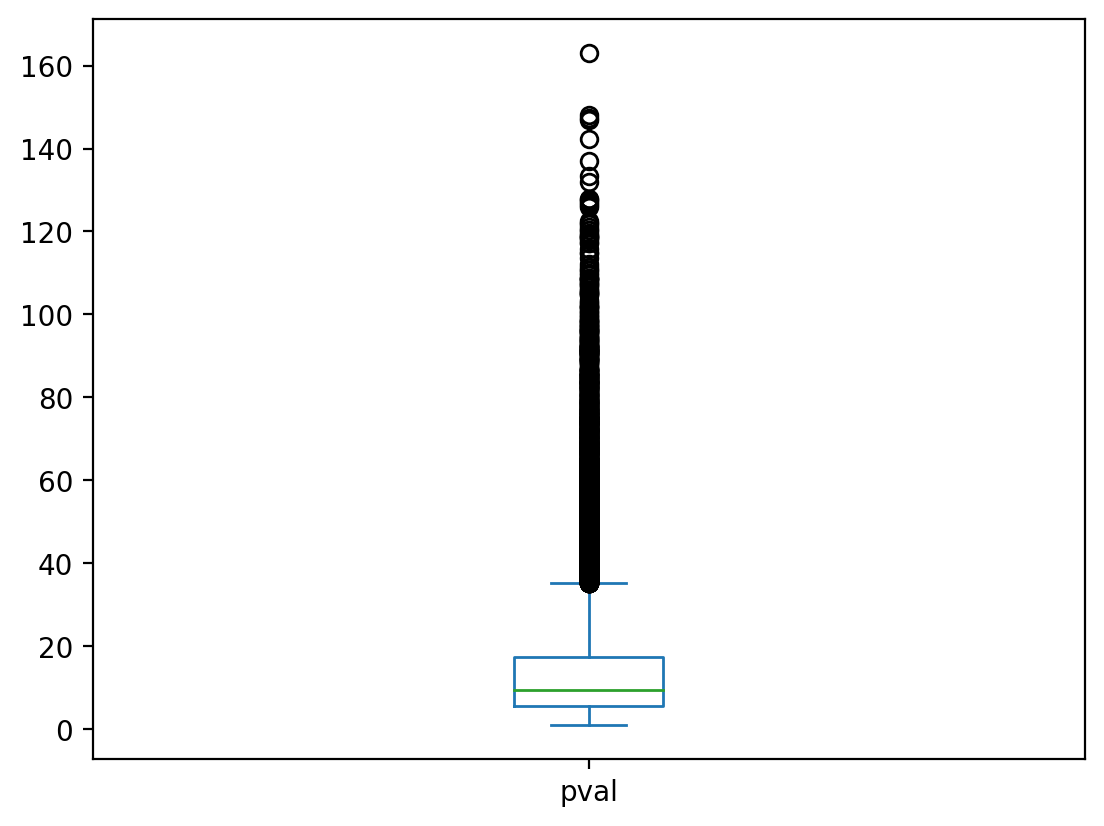

In [86]:
pval = df2['pval']
pval.plot(kind = 'box')
plt.show()

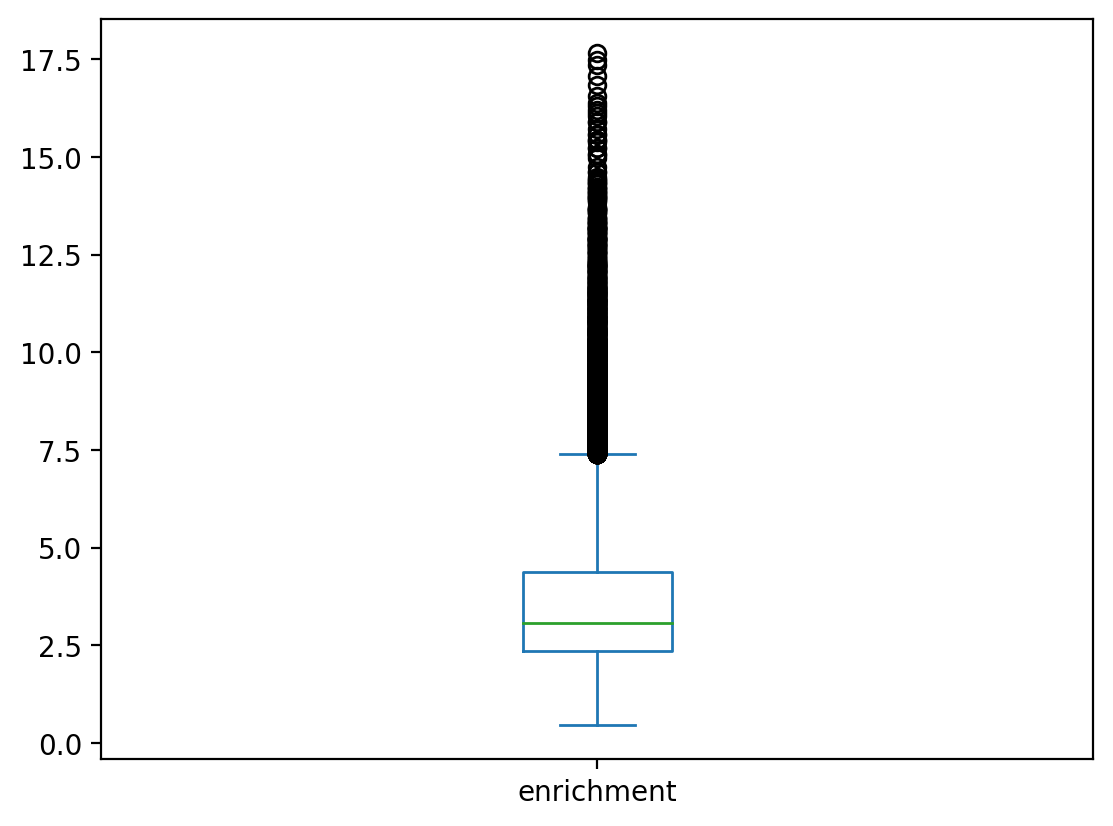

In [87]:
enrichment = df2['enrichment']
enrichment.plot(kind = 'box')
plt.show()

In [90]:
# Release Resources
%%html

<p><b>Shutting down your kernel for this notebook to release resources.</b></p>
<button class="sm-command-button" data-commandlinker-command="kernelmenu:shutdown" style="display:none;">Shutdown Kernel</button>
        
<script>
try {
    els = document.getElementsByClassName("sm-command-button");
    els[0].click();
}
catch(err) {
    // NoOp
}    
</script>

SyntaxError: invalid syntax (<ipython-input-90-c3ac5801f744>, line 4)

In [89]:
%%javascript

try {
    Jupyter.notebook.save_checkpoint();
    Jupyter.notebook.session.delete();
}
catch(err) {
    // NoOp
}

<IPython.core.display.Javascript object>